# Please open this notebook with Colab

In [1]:
# Code Work while tensorflow version is 2.2.0
!pip install tensorflow==2.2.0

     |████████████████████████████████| 516.2MB 33kB/s 
     |████████████████████████████████| 3.0MB 48.4MB/s 
     |████████████████████████████████| 460kB 51.8MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


# import modules

In [2]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import (Input, Dense, Dropout, Activation,
                                     BatchNormalization, Flatten,
                                     Conv2D, MaxPooling2D)
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
print(tf.__version__)

2.2.0


# Loading Data (Cifar10)

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
num_classes = 10

# convert to one hot
y_train = np.eye(num_classes, dtype='float32')[y_train[:, 0]]
y_test = np.eye(num_classes, dtype='float32')[y_test[:, 0]]

170500096/170498071 [==============================] - 4s 0us/step


In [4]:
# show train, test data shape
print(*map(lambda x:x.shape, [x_train, y_train, x_test, y_test]), sep='\n')

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


# Build a Simple CNN Model

In [5]:
inputs = Input(shape=x_train.shape[1:])

x = Conv2D(32, (3, 3), activation='relu')(inputs)

x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu')(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
outputs = Dense(num_classes, activation='softmax')(x)


cnn_model = keras.Model(inputs=inputs, outputs=outputs)

In [6]:
learning_rate = 0.0001
optimizer = keras.optimizers.Adam(lr=learning_rate)

cnn_model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

## Model Summary

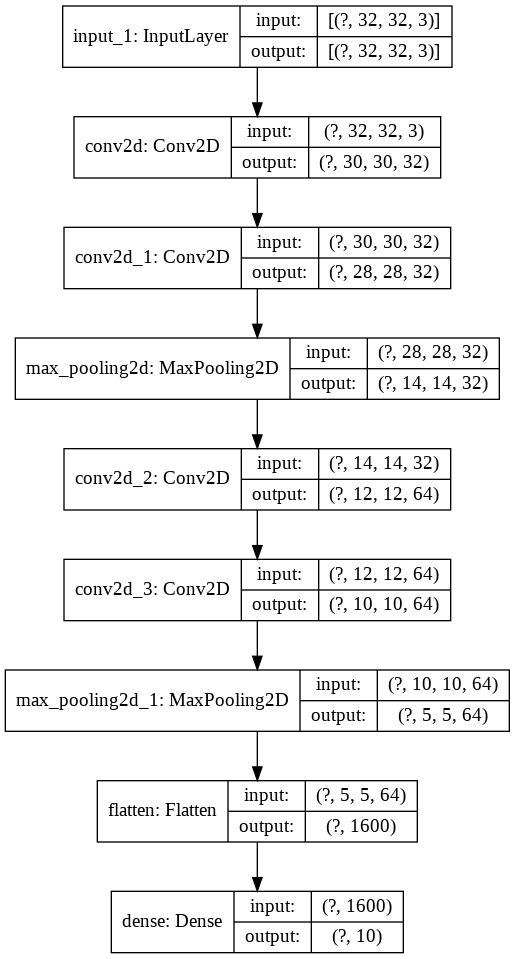

In [7]:
keras.utils.plot_model(cnn_model, show_shapes=True)

## Training the Model

In [8]:
cnn_history = cnn_model.fit(x_train, y_train,
                            batch_size=32,
                            epochs=20,
                            validation_data=(x_test, y_test),
                            verbose=1)
cnn_model.save("Cifar10_CNN.h5")

Epoch 1/20
1563/1563 [==============================] - 7s 4ms/step - loss: 2.1128 - accuracy: 0.3248 - val_loss: 1.5789 - val_accuracy: 0.4337
Epoch 2/20
1563/1563 [==============================] - 6s 4ms/step - loss: 1.4636 - accuracy: 0.4796 - val_loss: 1.3895 - val_accuracy: 0.5088
Epoch 3/20
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2734 - accuracy: 0.5506 - val_loss: 1.2411 - val_accuracy: 0.5643
Epoch 4/20
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1449 - accuracy: 0.6005 - val_loss: 1.2469 - val_accuracy: 0.5654
Epoch 5/20
1563/1563 [==============================] - 6s 4ms/step - loss: 1.0472 - accuracy: 0.6386 - val_loss: 1.1098 - val_accuracy: 0.6121
Epoch 6/20
1563/1563 [==============================] - 6s 4ms/step - loss: 0.9644 - accuracy: 0.6669 - val_loss: 1.0990 - val_accuracy: 0.6181
Epoch 7/20
1563/1563 [==============================] - 6s 4ms/step - loss: 0.9010 - accuracy: 0.6878 - val_loss: 1.0121 - val_accuracy:

# Interger quantization

## Define data generator

In [9]:
take = 1000
def representative_data_gen():
  for image in x_train[:take]:
    image = image.astype(np.float32)
    image = np.expand_dims(image, axis=0)
    yield [image]
gen = representative_data_gen

### If image shape does not match input shape

In [10]:
# take = 1000
# import cv2
# def representative_data_gen(model):
#   shape = tuple(cnn_model.input.shape[1:3])
#   for image in x_train[:take]:
#     image = image.astype(np.float32)
#     image = cv2.resize(image, shape)
#     image = np.expand_dims(image, axis=0)
#     yield [image]
# gen = lambda:representative_data_gen(cnn_model)

### Or you just want to feed random noise

In [11]:
# take = 1000
# def representative_data_gen(model):
#   shape = tuple(cnn_model.input.shape[1:])
#   for itr in range(take):
#     noise = np.random.random(shape).astype(np.float32)
#     noise = np.expand_dims(noise, axis=0)
#     yield [image]
# gen = lambda:representative_data_gen(cnn_model)

## Go Quantize Model

In [12]:
model_name_quantize = "Cifar10_CNN_quant.tflite"

converter = tf.lite.TFLiteConverter.from_keras_model(cnn_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

converter.representative_dataset = gen
tflite_model = converter.convert()

open(model_name_quantize, 'wb').write(tflite_model)

92832

# Inference your tflite model

## Load tflite model

In [13]:
# interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter = tf.lite.Interpreter(model_path="Cifar10_CNN_quant.tflite")
interpreter.allocate_tensors()

## Get input and output tensors.

In [14]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']
input_shape

array([ 1, 32, 32,  3], dtype=int32)

## Move data to input tensor

In [15]:
# input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
input_data = np.expand_dims(x_train[0],0).astype(np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

## running your model

In [16]:
interpreter.invoke()

## get output data
The function `get_tensor()` returns a copy of the tensor data.<br>
Use `tensor()` in order to get a pointer to the tensor.

In [17]:
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[0.        0.        0.        0.0078125 0.        0.        0.9921875
  0.        0.        0.       ]]


## Test Accuracy on Colab with Pure tflite (i.e. without tpu)

In [18]:
# compute accuracy
N = 500
Counter_True = 0
for img, y in tqdm(zip(x_test[:N], y_test[:N])):
  img = np.expand_dims(img ,0).astype(np.float32)
  interpreter.set_tensor(input_details[0]['index'], img)
  interpreter.invoke()
  pred_y = interpreter.get_tensor(output_details[0]['index'])
  flag = np.argmax(y) == np.argmax(pred_y)
  Counter_True += flag
Counter_True/N

500it [00:20, 24.66it/s]


0.646

# Convert tflite model to edgetpu version

In [19]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list
! sudo apt-get update
! sudo apt-get install edgetpu-compiler	

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   653  100   653    0     0  19205      0 --:--:-- --:--:-- --:--:-- 19205
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [95.7 kB]
Get:8 https

In [20]:
!edgetpu_compiler -s {model_name_quantize}

Edge TPU Compiler version 14.1.317412892

Model compiled successfully in 65 ms.

Input model: Cifar10_CNN_quant.tflite
Input size: 90.66KiB
Output model: Cifar10_CNN_quant_edgetpu.tflite
Output size: 184.79KiB
On-chip memory used for caching model parameters: 177.50KiB
On-chip memory remaining for caching model parameters: 7.60MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 11
Operation log: Cifar10_CNN_quant_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 9
Number of operations that will run on CPU: 2

Operator                       Count      Status

FULLY_CONNECTED                1          Mapped to Edge

# Move files to edge device
* \*_quant.tflite
* \*_quant_edgetpu.*